In [1]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [2]:
import os 
import numpy as np
import random
import cv2
from PIL import Image, ImageEnhance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle
from skimage import exposure, filters

In [3]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for img in os.listdir(os.path.join(train_dir,label)):
        train_paths.append(os.path.join(train_dir,label,img))
        train_labels.append(label)

train_paths,train_labels = shuffle(train_paths,train_labels)


In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for img in os.listdir(os.path.join(test_dir,label)):
        test_paths.append(os.path.join(test_dir,label,img))
        test_labels.append(label)

test_paths,test_labels = shuffle(test_paths,test_labels)


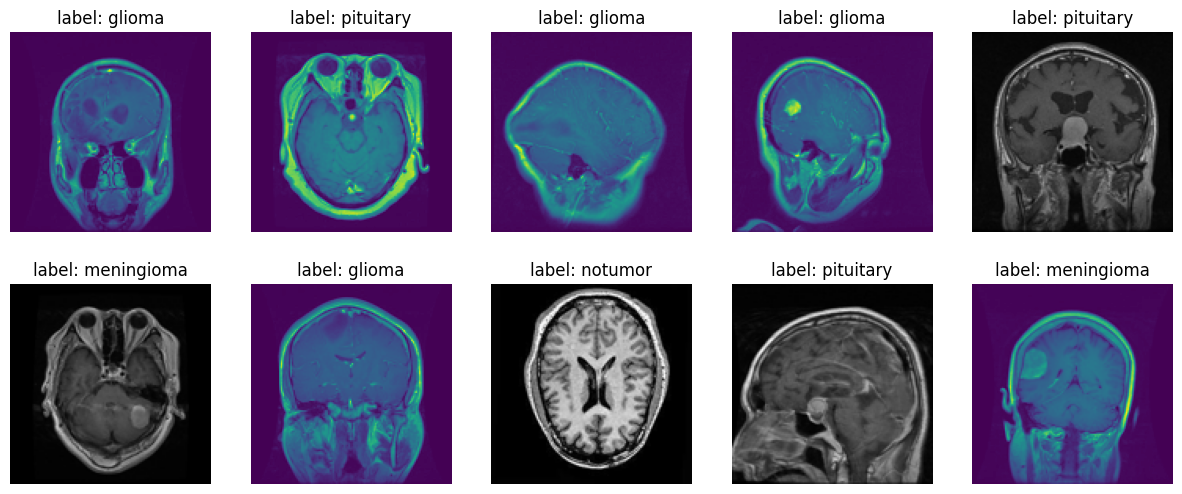

In [5]:
import matplotlib.pyplot as plt
random_indices = random.sample(range(len(train_paths)),10)
fig,axes = plt.subplots(2,5,figsize=(15,6))
axes= axes.ravel()
for i,idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img=img.resize((128,128))
    axes[i].imshow(img)
    axes[i].set_title(f"label: {train_labels[idx]}")
    axes[i].axis('off')

In [6]:
def noise_reduction(image):
    """Appling Gaussian Blur to reduce noise"""
    return cv2.GaussianBlur(image,(5,5),0)


def skull_strip(image):
    """Appling Otsu's Thresholding to remove the skull"""
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return cv2.bitwise_and(image,image,mask=mask)

def adaptive_histogram_equalization(image):
    """Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)"""
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab = cv2.merge((l,a,b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def normalize_image(image):
    """Normalize image pixels to [0,1]"""
    return image / 255.0

def augment_image(image):
    """Apply Brightness, Contrast, and Random Flips"""
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)
    if random.random() > 0.5:
        image = cv2.flip(image, 1)

    return image


def preprocess_image(path):
    """Complete preprocessing pipeline for a single image"""
    image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image = img_to_array(image).astype(np.uint8)
    
    # Apply preprocessing steps
    image = noise_reduction(image)
    image = skull_strip(image)
    image = adaptive_histogram_equalization(image)
    image = augment_image(image)
    image = normalize_image(image)
    
    return image

    
def open_images(paths):
    """Load and preprocess batch of images"""
    images = [preprocess_image(path) for path in paths]
    return np.array(images)

def encoder_label(labels):
    unique_labels=os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

def data_generator(paths, labels, batch_size=12, epochs=1):
    """Generate batches of preprocessed images and encoded labels"""
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i+batch_size]
            batch_labels = encoder_label(batch_labels)
            yield batch_images, batch_labels
    

In [7]:
IMAGE_SIZE=128
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model=Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)),activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

batch_size = 12
steps = int(len(train_paths)/batch_size)
epochs=10

history = model.fit(data_generator(train_paths,train_labels,batch_size=batch_size,epochs=epochs),epochs=epochs,steps_per_epoch=steps) 

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 58s 104ms/step - loss: 0.6830 - sparse_categorical_accuracy: 0.7389
Epoch 2/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.3082 - sparse_categorical_accuracy: 0.8890
Epoch 3/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - loss: 0.2240 - sparse_categorical_accuracy: 0.9175
Epoch 4/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.1619 - sparse_categorical_accuracy: 0.9382
Epoch 5/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - loss: 0.1401 - sparse_categorical_accuracy: 0.9483
Epoch 6/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - loss: 0.1058 - sparse_categorical_accuracy: 0.9610
Epoch 7/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - loss: 0.0770 - sparse_categorical_accuracy: 0.9738
Epoch 8/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - loss: 0.0636 - sparse_categorical_accuracy: 0.9776
Epoch 9/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - loss: 0.0505 - sparse_categorical_ac

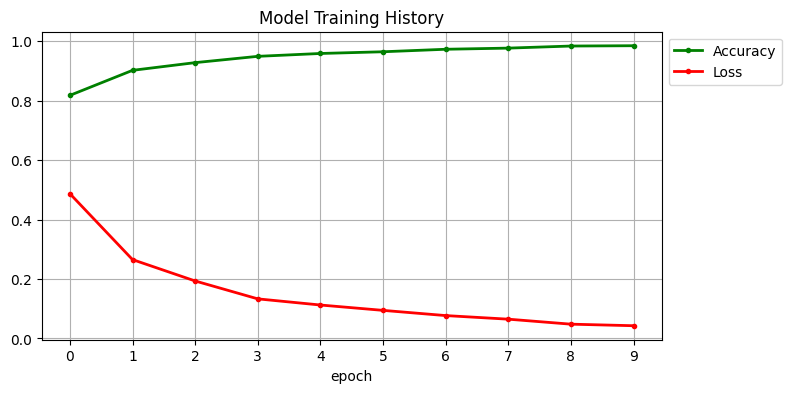

In [8]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix,auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
test_images = open_images(test_paths)
test_labels_encoded = encoder_label(test_labels)
test_predictions = model.predict(test_images)

print("Classification Report:")
print(classification_report(test_labels_encoded,np.argmax(test_predictions,axis=1)))


41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       300
           1       0.99      0.99      0.99       405
           2       0.98      0.92      0.95       306
           3       0.95      0.97      0.96       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



Confusion Matrix:
[[296   2   2   0]
 [  1 401   0   3]
 [  8   2 283  13]
 [  2   2   4 292]]


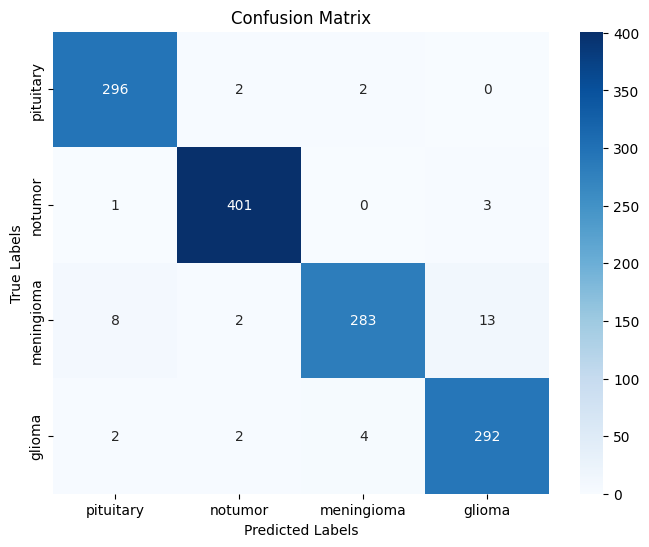

In [10]:
conf_matrix = confusion_matrix(test_labels_encoded,np.argmax(test_predictions,axis=1))
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [11]:
model.save('model12.h5')

In [12]:
from tensorflow.keras.models import load_model
model = load_model('model12.h5')

Brain Tumor Detection System from MRI scan


In [13]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'notumor', 'meningioma', 'glioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  
        img_array = np.expand_dims(img_array, axis=0)  
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


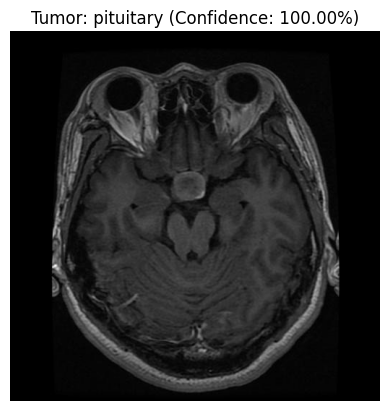

In [14]:
image_path ='/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0009.jpg'
detect_and_display(image_path, model)

In [15]:
import os

print(os.listdir('/kaggle/working'))

['model12.h5', '__notebook__.ipynb']


In [16]:
from IPython.display import FileLink
FileLink(r'model12.h5')

/kaggle/working/model12.h5